## Benchmark model

### Train, test and validation split

IBM Stock train, test and validation split

In [59]:
train_size = int(len(df_ibm) * 0.90)
test_size = int(len(df_ibm) * 0.08)
valid_size = len(df_ibm) - (train_size + test_size)
df_ibm_train, df_ibm_test, df_ibm_valid = df_ibm[0:train_size].copy(),\
                                            df_ibm[train_size:train_size+test_size].copy(),\
                                            df_ibm[train_size+test_size:len(df_ibm)].copy()
print(len(df_ibm), len(df_ibm_train), len(df_ibm_test), len(df_ibm_valid))

14894 13404 1191 299


In [60]:
assert(len(df_ibm) == (len(df_ibm_train) + len(df_ibm_test) + len(df_ibm_valid)))

Amazon Stock train test split

In [61]:
train_size = int(len(df_amzn) * 0.90)
test_size = int(len(df_amzn) * 0.08)
valid_size = len(df_amzn) - (train_size + test_size)
df_amzn_train, df_amzn_test, df_amzn_valid = df_amzn[0:train_size].copy(),\
                                            df_amzn[train_size:train_size+test_size].copy(),\
                                            df_amzn[train_size+test_size:len(df_amzn)].copy()
print(len(df_amzn), len(df_amzn_train), len(df_amzn_test), len(df_amzn_valid))

5989 5390 479 120


In [62]:
assert(len(df_amzn) == (len(df_amzn_train) + len(df_amzn_test) + len(df_amzn_valid)))

Apple Inc. Stock train test split

In [63]:
train_size = int(len(df_aapl) * 0.90)
test_size = int(len(df_aapl) * 0.08)
valid_size = len(df_aapl) - (train_size + test_size)
df_aapl_train, df_aapl_test, df_aapl_valid = df_aapl[0:train_size].copy(),\
                                            df_aapl[train_size:train_size+test_size].copy(),\
                                            df_aapl[train_size+test_size:len(df_aapl)].copy()
print(len(df_aapl), len(df_aapl_train), len(df_aapl_test), len(df_aapl_valid))

10140 9126 811 203


Alphabet Inc. Stock train test split

In [64]:
train_size = int(len(df_googl) * 0.90)
test_size = int(len(df_googl) * 0.08)
valid_size = len(df_googl) - (train_size + test_size)
df_googl_train, df_googl_test, df_googl_valid = df_googl[0:train_size].copy(),\
                                            df_googl[train_size:train_size+test_size].copy(),\
                                            df_googl[train_size+test_size:len(df_googl)].copy()
print(len(df_googl), len(df_googl_train), len(df_googl_test), len(df_googl_valid))

4163 3746 333 84


#### Simple Moving Average (SMA)

Moving average is a techical indicator that smooths real data oscillations over time.
It can aid in determining if an asset price will continue or if it will reverse a bull or bear trend.

In this notebook, I'll use Simple Moving Average indicator as a benchmark model.
In order to do this, I will compute it separately on training data and test data, to avoid leakage.

SMA will be used in the project for three purposes:
* Detect if some seasonal pattern is present in data
* A benchmark for deep learning model performance
* An additional feature to be used to train deep learning model

Before moving to feature engineering, reference date index to be used to build the model will be defined:

In [65]:
analysis_start_date = '2010-01-1'

Anyway, new feature will be computed on the whole dataframe. Plotting will be limited to `analysis_start_date`

In [66]:
from ta_utils.technical_indicators import moving_average, volatility

#### IBM stock moving averages

In [67]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))
    df_ibm[column_name] = moving_average(df_ibm['Adj Close'], window_size=mds)
    df_ibm_train[column_name] = moving_average(df_ibm_train['Adj Close'], window_size=mds)
    df_ibm_test[column_name] = moving_average(df_ibm_test['Adj Close'], window_size=mds)
    df_ibm_valid[column_name] = moving_average(df_ibm_valid['Adj Close'], window_size=mds)

In [68]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,NaN,NaN,NaN
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,NaN,NaN,NaN
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,NaN,NaN,NaN
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,NaN,NaN,NaN
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [69]:
df_ibm.fillna(method='backfill', inplace=True)

In [70]:
df_ibm.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,1.831034,1.806507,1.787152
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,1.831034,1.806507,1.787152
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,1.831034,1.806507,1.787152
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,1.831034,1.806507,1.787152
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,1.831034,1.806507,1.787152


In [71]:
df_ibm_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,1.858243,390000,NaN,NaN,NaN
1962-01-03,7.626667,7.693333,7.626667,7.693333,1.874485,292500,NaN,NaN,NaN
1962-01-04,7.693333,7.693333,7.613333,7.616667,1.855805,262500,NaN,NaN,NaN
1962-01-05,7.606667,7.606667,7.453333,7.466667,1.819257,367500,NaN,NaN,NaN
1962-01-08,7.460000,7.460000,7.266667,7.326667,1.785148,547500,NaN,NaN,NaN


In [72]:
df_ibm_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2015-04-02,159.520004,162.539993,158.889999,160.449997,124.202393,4671600,NaN,NaN,NaN
2015-04-06,159.690002,162.800003,158.699997,162.039993,125.433212,3465700,NaN,NaN,NaN
2015-04-07,161.669998,163.839996,161.619995,162.070007,125.456367,3148000,NaN,NaN,NaN
2015-04-08,161.720001,163.550003,161.009995,161.850006,125.286148,2524300,NaN,NaN,NaN
2015-04-09,161.699997,162.470001,160.720001,162.339996,125.665375,2263500,NaN,NaN,NaN


In [73]:
df_ibm_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2019-12-24,135.610001,135.619995,134.610001,134.979996,126.562637,1202100,NaN,NaN,NaN
2019-12-26,134.979996,135.309998,134.649994,134.910004,126.497017,2129700,NaN,NaN,NaN
2019-12-27,135.000000,135.750000,134.869995,135.270004,126.834549,2752200,NaN,NaN,NaN
2019-12-30,135.199997,135.300003,132.500000,132.809998,124.527962,4118900,NaN,NaN,NaN
2019-12-31,132.529999,134.119995,132.399994,134.039993,125.681244,3777500,NaN,NaN,NaN


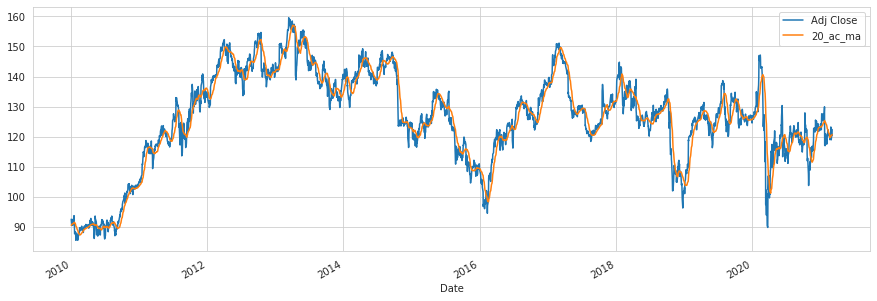

In [74]:
df_ibm[analysis_start_date:end][['Adj Close', '20_ac_ma']].plot(legend=True,figsize=(15,5))

#### Apple stock moving averages

#### Apple stock moving averages

In [75]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_aapl[column_name] = moving_average(df_aapl['Adj Close'], window_size=mds)
    df_aapl_train[column_name] = moving_average(df_aapl_train['Adj Close'], window_size=mds)
    df_aapl_test[column_name] = moving_average(df_aapl_test['Adj Close'], window_size=mds)
    df_aapl_valid[column_name] = moving_average(df_aapl_valid['Adj Close'], window_size=mds)

In [76]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,NaN,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,NaN,NaN,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,NaN,NaN,NaN
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,NaN,NaN,NaN
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [77]:
df_aapl.fillna(method='backfill', inplace=True)

In [78]:
df_aapl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,0.101975,0.108974,0.104248
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,0.101975,0.108974,0.104248
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,0.101975,0.108974,0.104248
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,0.101975,0.108974,0.104248
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,0.101975,0.108974,0.104248


In [79]:
df_aapl_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100922,469033600,NaN,NaN,NaN
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095657,175884800,NaN,NaN,NaN
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088636,105728000,NaN,NaN,NaN
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090830,86441600,NaN,NaN,NaN
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093463,73449600,NaN,NaN,NaN


In [80]:
df_aapl_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2017-02-22,34.107498,34.279999,34.027500,34.277500,32.555794,83347600,NaN,NaN,NaN
2017-02-23,34.345001,34.369999,34.075001,34.132500,32.418076,83152800,NaN,NaN,NaN
2017-02-24,33.977501,34.165001,33.820000,34.165001,32.448948,87106400,NaN,NaN,NaN
2017-02-27,34.285000,34.360001,34.070000,34.232498,32.513054,81029600,NaN,NaN,NaN
2017-02-28,34.270000,34.360001,34.174999,34.247501,32.527302,93931600,NaN,NaN,NaN


In [81]:
df_aapl_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2020-05-13,78.037498,78.987503,75.802498,76.912498,76.527496,200622400,NaN,NaN,NaN
2020-05-14,76.127502,77.447502,75.382500,77.385002,76.997635,158929200,NaN,NaN,NaN
2020-05-15,75.087502,76.974998,75.052498,76.927498,76.542412,166348400,NaN,NaN,NaN
2020-05-18,78.292503,79.125000,77.580002,78.739998,78.345848,135372400,NaN,NaN,NaN
2020-05-19,78.757500,79.629997,78.252502,78.285004,77.893127,101729600,NaN,NaN,NaN


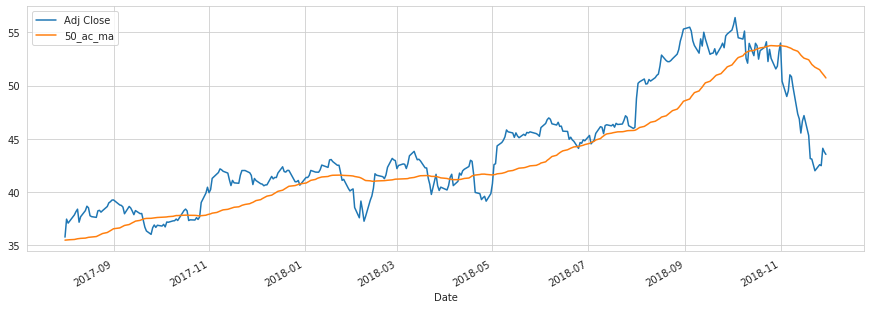

In [82]:
df_aapl[start_date:end_date][['Adj Close', '50_ac_ma']].plot(legend=True,figsize=(15,5))

#### Amazon.com stock moving averages

In [83]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_amzn[column_name] = moving_average(df_amzn['Adj Close'], window_size=mds)
    df_amzn_train[column_name] = moving_average(df_amzn_train['Adj Close'], window_size=mds)
    df_amzn_test[column_name] = moving_average(df_amzn_test['Adj Close'], window_size=mds)
    df_amzn_valid[column_name] = moving_average(df_amzn_valid['Adj Close'], window_size=mds)

In [84]:
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,NaN,NaN,NaN
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,NaN,NaN,NaN
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [85]:
df_amzn.fillna(method='backfill', inplace=True)

In [86]:
df_amzn.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,1.597396,1.57474,1.772813
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,1.597396,1.57474,1.772813
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,1.597396,1.57474,1.772813
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,1.597396,1.57474,1.772813
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,1.597396,1.57474,1.772813


In [87]:
df_amzn_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,NaN,NaN,NaN
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,NaN,NaN,NaN
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,NaN,NaN,NaN
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,NaN,NaN,NaN


In [88]:
df_amzn_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2018-10-15,1795.000000,1795.050049,1734.229980,1760.949951,1760.949951,6437200,NaN,NaN,NaN
2018-10-16,1783.500000,1823.880005,1761.550049,1819.959961,1819.959961,5859900,NaN,NaN,NaN
2018-10-17,1842.790039,1845.000000,1807.000000,1831.729980,1831.729980,5295200,NaN,NaN,NaN
2018-10-18,1821.489990,1830.150024,1767.869995,1770.719971,1770.719971,5874000,NaN,NaN,NaN
2018-10-19,1785.160034,1809.099976,1753.000000,1764.030029,1764.030029,5907200,NaN,NaN,NaN


In [89]:
df_amzn_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2020-09-10,3307.219971,3349.889893,3170.550049,3175.110107,3175.110107,5330700,NaN,NaN,NaN
2020-09-11,3208.689941,3217.340088,3083.979980,3116.219971,3116.219971,5094000,NaN,NaN,NaN
2020-09-14,3172.939941,3187.389893,3096.000000,3102.969971,3102.969971,4529600,NaN,NaN,NaN
2020-09-15,3136.159912,3175.020020,3108.919922,3156.129883,3156.129883,4021500,NaN,NaN,NaN
2020-09-16,3179.989990,3187.239990,3074.149902,3078.100098,3078.100098,4512200,NaN,NaN,NaN


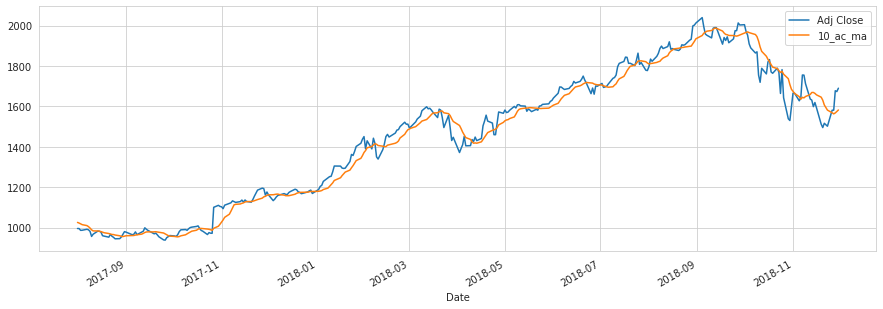

In [90]:
df_amzn[start_date:end_date][['Adj Close', '10_ac_ma']].plot(legend=True,figsize=(15,5))

#### Alphabet Inc. stock moving averages

In [91]:
# moving average sizes in days
ma_d_sz = [10,20,50]

# adding moving average columns to dataframe
for mds in ma_d_sz:
    column_name = "%s_ac_ma" %(str(mds))    
    df_googl[column_name] = moving_average(df_googl['Adj Close'], window_size=mds)
    df_googl_train[column_name] = moving_average(df_googl_train['Adj Close'], window_size=mds)
    df_googl_test[column_name] = moving_average(df_googl_test['Adj Close'], window_size=mds)
    df_googl_valid[column_name] = moving_average(df_googl_valid['Adj Close'], window_size=mds)

In [92]:
df_googl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,NaN,NaN,NaN
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,NaN,NaN,NaN
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,NaN,NaN,NaN
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,NaN,NaN,NaN
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,NaN,NaN,NaN


Moving average feature is empty for the first *n* days, where *n* is the window size, so I'll use some backfill to fill NaN values

In [93]:
df_googl.fillna(method='backfill', inplace=True)

In [94]:
df_googl.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,52.432933,52.692943,63.586987
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,52.432933,52.692943,63.586987
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,52.432933,52.692943,63.586987
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,52.432933,52.692943,63.586987
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,52.432933,52.692943,63.586987


In [95]:
df_googl_train.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096,NaN,NaN,NaN
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,NaN,NaN,NaN
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,NaN,NaN,NaN
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,NaN,NaN,NaN
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,NaN,NaN,NaN


In [96]:
df_googl_test.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2019-07-09,1110.319946,1127.859985,1107.150024,1124.290039,1124.290039,1473600,NaN,NaN,NaN
2019-07-10,1132.319946,1142.339966,1130.660034,1140.910034,1140.910034,1535500,NaN,NaN,NaN
2019-07-11,1146.160034,1153.239990,1139.530029,1144.079956,1144.079956,1300200,NaN,NaN,NaN
2019-07-12,1142.930054,1147.500000,1138.560059,1145.339966,1145.339966,1093900,NaN,NaN,NaN
2019-07-15,1145.339966,1150.680054,1140.000000,1150.510010,1150.510010,1058200,NaN,NaN,NaN


In [97]:
df_googl_valid.head()

,Open,High,Low,Close,Adj Close,Volume,10_ac_ma,20_ac_ma,50_ac_ma
Date,,,,,,,,,
2020-10-30,1667.439941,1681.319946,1601.569946,1616.109985,1616.109985,4993900,NaN,NaN,NaN
2020-11-02,1623.540039,1658.239990,1614.239990,1624.319946,1624.319946,2211400,NaN,NaN,NaN
2020-11-03,1630.760010,1659.000000,1612.109985,1645.660034,1645.660034,1571600,NaN,NaN,NaN
2020-11-04,1705.579956,1770.030029,1703.000000,1745.849976,1745.849976,3567100,NaN,NaN,NaN
2020-11-05,1770.449951,1791.819946,1741.030029,1762.500000,1762.500000,1987900,NaN,NaN,NaN


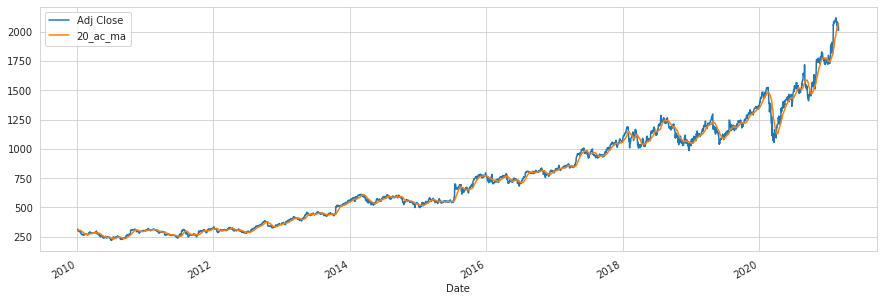

In [98]:
df_googl[analysis_start_date:end][['Adj Close', '20_ac_ma']].plot(legend=True,figsize=(15,5))

### Metrics computation

Computing metrics on the benchmark model will give me a good reference to evaluate the deep learning model after training.

As can be presumed and seen from data prints, first `n` values of validation data are `NaN` so, it will be better just to exclude the first `n-1` values from the validation set to avoid misleading values to be catch in metrics evaluation. 

In [99]:
from sklearn.metrics import mean_squared_error

#### IBM stock

In [100]:
n = 10
ma_str = str(n)+'_ac_ma'

In [101]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid.iloc[n-1:][ma_str])

In [102]:
print(ibm_ma_mse_loss)

20.918277026236694


In [103]:
n = 20
ma_str = str(n)+'_ac_ma'

In [104]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid[n-1:][ma_str])

In [105]:
print(ibm_ma_mse_loss)

50.31336934017377


In [106]:
n = 50
ma_str = str(n)+'_ac_ma'

In [107]:
ibm_ma_mse_loss = mean_squared_error(df_ibm_valid.iloc[n-1:]['Adj Close'], df_ibm_valid[n-1:][ma_str])

In [108]:
print(ibm_ma_mse_loss)

82.56896212876177


#### Apple Inc. stock

In [109]:
n = 10
ma_str = str(n)+'_ac_ma'

In [110]:
aapl_ma_mse_loss = mean_squared_error(df_aapl_valid.iloc[n-1:]['Adj Close'], df_aapl_valid.iloc[n-1:][ma_str])

In [111]:
print(aapl_ma_mse_loss)

18.972150097454808


In [112]:
n = 20
ma_str = str(n)+'_ac_ma'

In [113]:
aapl_ma_mse_loss = mean_squared_error(df_aapl_valid.iloc[n-1:]['Adj Close'], df_aapl_valid[n-1:][ma_str])

In [114]:
print(aapl_ma_mse_loss)

40.603920381056696


In [115]:
n = 50
ma_str = str(n)+'_ac_ma'

In [116]:
aapl_ma_mse_loss = mean_squared_error(df_aapl_valid.iloc[n-1:]['Adj Close'], df_aapl_valid[n-1:][ma_str])

In [117]:
print(aapl_ma_mse_loss)

110.41320400978593


#### Amazon.com stock

In [118]:
n = 10
ma_str = str(n)+'_ac_ma'

In [119]:
amzn_ma_mse_loss = mean_squared_error(df_amzn_valid.iloc[n-1:]['Adj Close'], df_amzn_valid.iloc[n-1:][ma_str])

In [120]:
print(amzn_ma_mse_loss)

6059.613747694114


In [121]:
n = 20
ma_str = str(n)+'_ac_ma'

In [122]:
amzn_ma_mse_loss = mean_squared_error(df_amzn_valid.iloc[n-1:]['Adj Close'], df_amzn_valid[n-1:][ma_str])

In [123]:
print(amzn_ma_mse_loss)

9384.401128406415


In [124]:
n = 50
ma_str = str(n)+'_ac_ma'

In [125]:
amzn_ma_mse_loss = mean_squared_error(df_amzn_valid.iloc[n-1:]['Adj Close'], df_amzn_valid[n-1:][ma_str])

In [126]:
print(amzn_ma_mse_loss)

6861.506123047632


#### Alphabet Inc. stock

In [127]:
n = 10
ma_str = str(n)+'_ac_ma'

In [128]:
googl_ma_mse_loss = mean_squared_error(df_googl_valid.iloc[n-1:]['Adj Close'], df_googl_valid.iloc[n-1:][ma_str])

In [129]:
print(googl_ma_mse_loss)

2913.722604245833


In [130]:
n = 20
ma_str = str(n)+'_ac_ma'

In [131]:
googl_ma_mse_loss = mean_squared_error(df_googl_valid.iloc[n-1:]['Adj Close'], df_googl_valid[n-1:][ma_str])

In [132]:
print(googl_ma_mse_loss)

7876.979431529724


In [133]:
n = 50
ma_str = str(n)+'_ac_ma'

In [134]:
googl_ma_mse_loss = mean_squared_error(df_googl_valid.iloc[n-1:]['Adj Close'], df_googl_valid[n-1:][ma_str])

In [135]:
print(googl_ma_mse_loss)

33735.63074925932


Volatility

In [136]:
print(volatility(df_ibm_valid['Adj Close'], n))

50.41103336518167


In [137]:
print(volatility(df_aapl_valid['Adj Close'], n))

43.688573139817336


In [138]:
print(volatility(df_amzn_valid['Adj Close'], n))

4028.852233722834


In [139]:
print(volatility(df_googl_valid['Adj Close'], n))

4225.065785217152


As expected, loss augments as we observe moving average on larger windows.
Also, we can observe that Amazon.com and Alphabet Inc. have greater losses, that also corresponds to higher volatility.